# TAC Discrimination Analysis: 

# Within Participants who have seen both discrimination images @ the same duration in the Verbal Judgement experiment

In [1]:
import os 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy 
import scipy.stats as stats
import json
from sklearn.linear_model import LinearRegression


## Get discrimination data

In [2]:
def combineCSVs(datafolder, num_discrim_trials):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 
    
    returns:
        (1) combined dataframe of all discrimination data 
        (2) combined dataframe of all scene property rating data 
    """
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        discrim_data = []
        properties_data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                
                df_discrim = df[0:num_discrim_trials]
                discrim_data.append(df_discrim)
                # row 96 should be ignored - artifact of logging 
                df_properties = df[num_discrim_trials+1:]
                properties_data.append(df_properties)
                

        discrim_frame = pd.concat(discrim_data, axis=0, ignore_index=True)
        properties_frame = pd.concat(properties_data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            df = pd.read_csv(datafolder, index_col=None, header=0)
            df_discrim = df[0:num_discrim_trials]
            discrim_data.append(df_discrim)
            # row 96 should be ignored - artifact of logging 
            df_properties = df[num_discrim_trials+1:]
            properties_data.append(df_properties)
 
    return discrim_frame, properties_frame

In [3]:
# data_path = '/Users/pmahableshwarkar/Documents/Depth_Project/depth_discrimination/TAC_depth_discrimination_MTurk/data'

# data_path = '/Users/prachi/Documents/depth_duration/depth_discrimination/TAC_depth_discrimination_MTurk/data'

data_path = '/Users/prachi/Documents/depth_duration/depth_discrimination/pilot_V3_TAC_discrim_data'

In [4]:
raw_discrim, raw_ratings = combineCSVs(data_path, 100)

In [5]:
all_subjIDs = raw_discrim.subjID.unique()
len(all_subjIDs)

10

In [6]:
raw_discrim

subjID experimentName                 versionName  \
0    977976    DepthScenes  v2_duration_discrimination   
1    977976    DepthScenes  v2_duration_discrimination   
2    977976    DepthScenes  v2_duration_discrimination   
3    977976    DepthScenes  v2_duration_discrimination   
4    977976    DepthScenes  v2_duration_discrimination   
..      ...            ...                         ...   
995  125863    DepthScenes  v2_duration_discrimination   
996  125863    DepthScenes  v2_duration_discrimination   
997  125863    DepthScenes  v2_duration_discrimination   
998  125863    DepthScenes  v2_duration_discrimination   
999  125863    DepthScenes  v2_duration_discrimination   

                  sequenceName  \
0    discrim_jsons/j13_dr.json   
1    discrim_jsons/j13_dr.json   
2    discrim_jsons/j13_dr.json   
3    discrim_jsons/j13_dr.json   
4    discrim_jsons/j13_dr.json   
..                         ...   
995     discrim_jsons/j13.json   
996     discrim_jsons/j13.json   
997     discrim_jsons/j13.json   
998     discrim_jsons/j13.json   
999     discrim_jsons/j13.json   

                                                   url  selected_row  \
0    http://54.235.3.71/FacialAge/BNav_EC2/DepthDur...             1   
1    http://54.235.3.71/FacialAge/BNav_EC2/DepthDur...             1   
2    http://54.235.3.71/FacialAge/BNav_EC2/DepthDur...             1   
3    http://54.235.3.71/FacialAge/BNav_EC2/DepthDur...             1   
4    http://54.235.3.71/FacialAge/BNav_EC2/DepthDur...             1   
..                                                 ...           ...   
995  http://54.235.3.71/FacialAge/BNav_EC2/DepthDur...             4   
996  http://54.235.3.71/FacialAge/BNav_EC2/DepthDur...             4   
997  http://54.235.3.71/FacialAge/BNav_EC2/DepthDur...             4   
998  http://54.235.3.71/FacialAge/BNav_EC2/DepthDur...             4   
999  http://54.235.3.71/FacialAge/BNav_EC2/DepthDur...             4   

     windowWidth  windowHeight  screenWidth  screenHeight  ... trial_RT  \
0            813           773         1440           900  ...     1504   
1            813           773         1440           900  ...     2096   
2            813           773         1440           900  ...     1601   
3            813           773         1440           900  ...     2963   
4            813           773         1440           900  ...     2591   
..           ...           ...          ...           ...  ...      ...   
995         1366           625         1366           768  ...     1710   
996         1366           625         1366           768  ...     2458   
997         1366           625         1366           768  ...     1776   
998         1366           625         1366           768  ...     1736   
999         1366           625         1366           768  ...     1038   

    log_fixation  log_sceneDuration1 log_mask1 log_sceneDuration2  log_mask2  \
0           1001                 250      1001                249        500   
1           1001                1000      1000                999        500   
2           1001                 249      1000                249        500   
3           1001                1000      1001                999        501   
4           1002                 999      1001                999        501   
..           ...                 ...       ...                ...        ...   
995         1014                 248       996                246        508   
996         1003                1039       966                991        509   
997         1013                 992      1013                992        505   
998         1008                 995      1000                998        507   
999         1004                 259       998                238        513   

     experimentTime  totalTime  age  gender  
0               NaN    1110353   44   Woman  
1               NaN    1110353   44   Woman  
2               NaN    1110353   4

In [7]:
all_ages = raw_discrim.age.unique()
all_ages

array([44, 58, 30, 46, 54, 40, 28, 29, 50])

## <font color='red'> Data Cleaning </font> 



In [11]:
def catchTrial_cleaning(df, correct_requirement, catch_stimuli):
    '''
    Participants complete 8 catch trials total to ensure that they are doing the task.
    If less than 7/8 catch trials are correct, the participant is excluded.  
    '''
    all_subjIDs = df.subjID.unique()
    remove = []
    subj_sequence = {}
    df2_list = []
    sequence_count = {'discrim_jsons/j13_dr.json': 0,
                      'discrim_jsons/j13_rotated_dr.json': 0,
                      'discrim_jsons/j13_rotated.json': 0, 
                      'discrim_jsons/j13.json': 0}
    for subj in all_subjIDs:
#         print(subj)
        count_correct = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning
        # 
        subj_sequence[subj] = subj_df.sequenceName.unique()[0]
        
        # remove trials that are outside the outlier range
        c = 0
        c_missed = 0
        for idx, row in subj_df.iterrows():
            stim1 = row['stimulus_0']
            stim2 = row['stimulus_1']
            # TEMP SOLUTION FOR RANDOM PHP DATA SAVING PROBLEM 
            if type(stim1) == str:
                if stim1.split('/')[1] in catch_stimuli or stim2.split('/')[1] in catch_stimuli:
                    ####### VERSION WHERE CATCH TRIALS ARE ATTENTION CHECK: IMAGE 1 IS THE SAME AS IMAGE 2
                    c += 1
                    if row["discrim_choice"] == 3:
#                         print(row["discrim_choice"])
                        count_correct += 1
#                     else:
#                         print(row["discrim_choice"])
                    # remove catch trial 
                    cleaned_subj_df.drop([idx], inplace=True)
    #                 print(depth0, depth1, correct_choice, choice)
#         print(c_missed, 'Number of catch trials where participants did not see the target')
#         print(c)
#         print(count_correct)
        if count_correct < correct_requirement:
#             print('Number correct:', count_correct)
            remove.append(subj)
        else:
            sequence_count[subj_df.sequenceName.unique()[0]] += 1
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    print("Number of participants that did not pass the catch trial check:", len(remove))
    print("Participants that were removed:",remove)
    print("Sequences that need to be replaced:")
#     for subj in remove:
#         print(subj_sequence[subj])
    print("Sequence count:")
    print(sequence_count)
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
    
    return df2
    
    

In [12]:
# all_catch_stim = ['000375_2014-06-08_11-17-29_260595134347_rgbf000133-resize_2',
#               '000569_2014-06-09_22-51-47_260595134347_rgbf000141-resize_3',
#               '000787_2014-06-08_22-33-53_260595134347_rgbf000175-resize_1',
#               '002072_2014-06-24_21-48-06_260595134347_rgbf000115-resize_0',
#               '002364_2014-06-28_20-11-05_260595134347_rgbf000042-resize_0',
#               '002675_2014-06-13_16-08-49_094959634447_rgbf000151-resize_2',
#               '003125_2014-05-12_10-39-22_094959634447_rgbf000100-resize_0',
#               '003395_2014-05-20_15-39-18_094959634447_rgbf000101-resize_0',
#               '000454_2014-06-08_16-37-28_260595134347_rgbf000048-resize_2',
#               '000868_2014-06-09_20-49-52_260595134347_rgbf000064-resize_4',
#               '000953_2014-06-08_11-42-19_260595134347_rgbf000083-resize_0',
#               '001012_2014-06-08_23-19-38_260595134347_rgbf000057-resize_0',
#               '001170_2014-06-17_15-43-44_260595134347_rgbf000096-resize_6',
#               '001222_2014-06-17_16-24-06_260595134347_rgbf000073-resize_0',
#               '001498_2014-06-19_17-45-14_260595134347_rgbf000129-resize_4',
#               '001540_2014-06-20_17-01-05_260595134347_rgbf000086-resize_2']

all_catch_stim = ['000375_2014-06-08_11-17-29_260595134347_rgbf000133-resize_2',
                  '000569_2014-06-09_22-51-47_260595134347_rgbf000141-resize_3',
                  '000787_2014-06-08_22-33-53_260595134347_rgbf000175-resize_1',
                  '002072_2014-06-24_21-48-06_260595134347_rgbf000115-resize_0',
                  '001170_2014-06-17_15-43-44_260595134347_rgbf000096-resize_6',
                  '001222_2014-06-17_16-24-06_260595134347_rgbf000073-resize_0',
                  '001498_2014-06-19_17-45-14_260595134347_rgbf000129-resize_4',
                  '001540_2014-06-20_17-01-05_260595134347_rgbf000086-resize_2']

In [13]:
catch_cleaned_discrim = catchTrial_cleaning(raw_discrim, 7, all_catch_stim)

Number of participants that did not pass the catch trial check: 2
Participants that were removed: [977976, 125863]
Sequences that need to be replaced:
Sequence count:
{'discrim_jsons/j13_dr.json': 3, 'discrim_jsons/j13_rotated_dr.json': 2, 'discrim_jsons/j13_rotated.json': 2, 'discrim_jsons/j13.json': 1}


In [14]:
cleaned_ages = catch_cleaned_discrim.age.unique()
cleaned_ages

array([58, 30, 46, 54, 40, 28, 29])

In [15]:
def RT_cleaning(df, outlier_range, num_trials):
    all_subjIDs = df.subjID.unique()
    remove = []
    df2_list = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning
        
        # calculate subject's average trial RT
        average_trial_RT = subj_df["trial_RT"].mean()
        std_trial_RT = subj_df["trial_RT"].std()
        p_outlier_range = [(average_trial_RT - (3*std_trial_RT)), (average_trial_RT + (3*std_trial_RT))]
        
        # remove trials that are outside the outlier range
        for idx, row in subj_df.iterrows():
            RT = row['trial_RT']
            if RT < outlier_range[0]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
            if RT > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
            try:
                if RT < p_outlier_range[0]:
                    cleaned_subj_df.drop([idx], inplace=True)
                    count += 1
                if RT > p_outlier_range[1]:
                    cleaned_subj_df.drop([idx], inplace=True)
                    count += 1
            except:
                print("Trial already removed")
                
        threshold = math.floor(num_trials * 0.1)
        if count >= threshold:
            remove.append(subj)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    print("Number of Participants with 10% or more trials outside their RT range:", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
    
    return df2


In [16]:
cleaned_discrim = RT_cleaning(catch_cleaned_discrim, [250,5000], 94)


# cleaned_discrim = RT_cleaning(catch_cleaned_discrim, [250,5000], 32)

Trial already removed
Trial already removed
Trial already removed
Number of Participants with 10% or more trials outside their RT range: 0


In [17]:
def finalTrialCountCheck(df, num_trials):
    """
    If more then 10% of a participants data is missing, remove the participant
    """
    #List unique values in the df['subjID'] column\n",
    all_subjIDs = df.subjID.unique()
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_trials = len(subj_df.index)
        threshold_trials_remaining = num_trials - math.floor(num_trials * 0.1)
        
        if count_trials <= threshold_trials_remaining:
            remove.append(subj)
    print("Number of Participants with >= 10% trials removed:", len(remove))
    
    for index, row in df.iterrows():
        if row['subjID'] in remove:
            df.drop(index, inplace=True)
    
    print("Number of participants left:",len(df.subjID.unique()))
    
    return df

In [18]:
final_discrim = finalTrialCountCheck(cleaned_discrim, 94)

Number of Participants with >= 10% trials removed: 0
Number of participants left: 8


## Individual Discriminations

In [19]:
def get_accuracy(df):
    """
    * ACCURACY BASED ON THE KINECT
    args:
        df  
    returns:
        proportion of correct responses, count of correct responses, count of total trials  
    """
    count_correct = 0
    count_incorrect = 0
    count_total = 0
    count_missed = 0
    for idx, row in df.iterrows():
        choice = row["discrim_choice"]
        if choice == 2.0:
            count_missed += 1
        else:    
            count_total += 1
            depth0 = row["actual_depth_0"]
            depth1 = row["actual_depth_1"]
            if depth0 < depth1:
                correct_choice = 0
            if depth0 > depth1:
                correct_choice = 1
            if depth0 == depth1:
                # case where depths are equal 
                correct_choice = None
            if choice == correct_choice:
                count_correct += 1
    
    return count_correct/count_total, count_correct, count_total, count_missed

def get_RT(df):
    """
    args:
        df  
    returns:
        array of RTs, avg RT and std   
    """
    list_RTs = []
    for idx, row in df.iterrows():   
        stimulus_duration = row['log_sceneDuration2']
        RT = row["trial_RT"] - stimulus_duration
        list_RTs.append(RT)
    
    list_RTs = np.array(list_RTs)
    
    return list_RTs, np.mean(list_RTs) ,np.std(list_RTs)

In [20]:
def depth_differences(df):
    """
    args:
        df  
    returns:
        array of depth differences, avg depth differences and std   
    """
    depth_diffs = []
    for idx, row in df.iterrows():
        depth0 = row["actual_depth_0"]
        depth1 = row["actual_depth_1"]
        
        diff = abs(depth0-depth1)
        depth_diffs.append(diff)
    
    depth_diffs = np.array(depth_diffs)
    
    return depth_diffs, np.mean(depth_diffs) ,np.std(depth_diffs)
    

In [21]:
all_depth_diffs = depth_differences(final_discrim)

# add depth difference column to dataframe 
final_discrim.insert(18, "depth_difference", all_depth_diffs[0])

In [22]:
def individual_discrimination_stats(df):
    '''
    Individual discrimination performance and RT 
    '''
    all_stim0 = df.stimulus_0.unique()
    
    stimuli_stats = {}
    for stim0 in all_stim0:
        stim0_df = df.loc[df['stimulus_0'] == stim0]
        other_stim = stim0_df.stimulus_1.unique()[0]
        stim1_df = df.loc[df['stimulus_1'] == stim0]
        # df for a specific discrimination trial (collapsed on stim presentation order)
        stim_df = pd.concat([stim0_df, stim1_df], ignore_index=True)
        stim_250_df = stim_df[stim_df['duration'] == 250.0]
        stim_1000_df = stim_df[stim_df['duration'] == 1000.0] 
        
        stim_depthdiff = stim_df['depth_difference'][0]
        
        stim0_depth = stim_df['actual_depth_0'][0]
        stim1_depth = stim_df['actual_depth_1'][0]
        stim_depthbin = np.mean(np.array([stim0_depth,stim1_depth]))
        
        stim_acc_250 = get_accuracy(stim_250_df)
        stim_acc_1000 = get_accuracy(stim_1000_df)
        
        stim_RT_250 = get_RT(stim_250_df)
        stim_RT_1000 = get_RT(stim_1000_df)
        
        stimuli_stats[stim0] = {'stimulus_1': other_stim,
                                'accuracy_250': stim_acc_250,
                                'accuracy_1000': stim_acc_1000,
                                'avg_depth': stim_depthbin,
                                'depthdifference': stim_depthdiff, 
                                'RT_250': stim_RT_250,
                                'RT_1000': stim_RT_1000}
    
    return stimuli_stats

In [23]:
all_discrim_performance = individual_discrimination_stats(final_discrim)


In [24]:
# Load Target at Center Verbal Judgement Data 

# TAC_data_path = '/Users/pmahableshwarkar/Documents/Depth_Project/depth_duration_analysis/TAC_data'

TAC_data_path = '/Users/prachi/Documents/depth_duration/depth_duration_analysis/TAC_data'

raw_TAC_250 = pd.read_csv(TAC_data_path + '/raw_250_data.csv')
raw_TAC_500 = pd.read_csv(TAC_data_path + '/raw_500_data.csv')
raw_TAC_750 = pd.read_csv(TAC_data_path + '/raw_750_data.csv')
raw_TAC_1000 = pd.read_csv(TAC_data_path + '/raw_1000_data.csv')

n_TAC_250 = pd.read_csv(TAC_data_path + '/normalized_250_data.csv')
n_TAC_500 = pd.read_csv(TAC_data_path + '/normalized_500_data.csv')
n_TAC_750 = pd.read_csv(TAC_data_path + '/normalized_750_data.csv')
n_TAC_1000 = pd.read_csv(TAC_data_path + '/normalized_1000_data.csv')

In [25]:
# Load one TAC Discrimination json sequence 
# all sequences have the same image combinations for the trials, duration and order is counterbalanced 

# discrim_json0_path = '/Users/pmahableshwarkar/Documents/Depth_Project/depth_discrimination/TAC_depth_discrimination_MTurk/discrim_jsons/v2_shuffled_g0_dr.json'

discrim_json0_path = '/Users/prachi/Documents/depth_duration/depth_discrimination/discrimination_sequences/january2022/j13/j13_dr.json'

with open(discrim_json0_path) as f:
    discrim_json0 = json.load(f)
    
discrim_image_combos = []
for trial in discrim_json0:
    combo = (trial['image_path_target_0'][29:], trial['image_path_target_1'][29:])
    discrim_image_combos.append(combo)

In [27]:
# dictionary where key is one of the images in a discimrination trial, 
# and the value will be a list of all the subjects that saw both images at the same duration

discrim_trial_subjects_250 = {}
for combo in discrim_image_combos:
    discrim_trial_subjects_250[combo[0]] = []
    
# find subjects that saw BOTH discrimination trials at 250 ms

subjs_250 = raw_TAC_250.subjID.unique()

seqs = []
for subj in subjs_250:
    subj_df = raw_TAC_250.loc[raw_TAC_250['subjID'] == subj]
    for combo in discrim_image_combos:
        img0_path = 'depth_duration_stimuli/' + combo[0]
        dimg0_row = subj_df.loc[subj_df['stimulus'] == img0_path]
        
        img1_path = 'depth_duration_stimuli/' + combo[1]
        dimg1_row = subj_df.loc[subj_df['stimulus'] == img1_path]
        
        
        if len(dimg0_row) == 1:
             if len(dimg1_row) == 1:
                if subj not in discrim_trial_subjects_250[combo[0]]:
                    discrim_trial_subjects_250[combo[0]].append(subj)
                    seqs.append(subj_df.sequenceName.unique()[0])
        
# print(set(seqs))

In [28]:
len(set(seqs))

192

In [164]:
for key in discrim_trial_subjects_250:
    print(len(discrim_trial_subjects_250[key]))

10
17
14
11
0
11
15
11
0
13
13
12
0
10
13
7
12
5
15
0
9
12
15
11
16
0
11
14
7
0
10
16
13
8
0
11
14
0
10
10


In [29]:
# dictionary where key is one of the images in a discimrination trial, 
# and the value will be a list of all the subjects that saw both images at the same duration

discrim_trial_subjects_1000 = {}
for combo in discrim_image_combos:
    discrim_trial_subjects_1000[combo[0]] = []
    
# find subjects that saw BOTH discrimination trials at 250 ms

subjs_1000 = raw_TAC_1000.subjID.unique()

for subj in subjs_1000:
    subj_df = raw_TAC_1000.loc[raw_TAC_1000['subjID'] == subj]
    for combo in discrim_image_combos:
        img0_path = 'depth_duration_stimuli/' + combo[0]
        dimg0_row = subj_df.loc[subj_df['stimulus'] == img0_path]
        
        img1_path = 'depth_duration_stimuli/' + combo[1]
        dimg1_row = subj_df.loc[subj_df['stimulus'] == img1_path]
        
        
        if len(dimg0_row) == 1:
             if len(dimg1_row) == 1:
                if subj not in discrim_trial_subjects_1000[combo[0]]:
                    discrim_trial_subjects_1000[combo[0]].append(subj)


In [166]:
a = 0
for key in discrim_trial_subjects_1000:
#     print(len(discrim_trial_subjects_1000[key]))
    a += len(discrim_trial_subjects_1000[key])
a/len(discrim_trial_subjects_1000)

9.4

In [167]:
# because of outlier cleaning, the numbers are not even across all discrimination trials

In [30]:
def trial_pivotTable(data):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each individual target (stimulus) the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """
    
    avg_tables = []
    std_tables = []
    result_tables = []
    cond = 0
    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    for duration in data: #generate pivot tables for data statistics (avg, std, sem)
        actual = pd.pivot_table(duration,  values = ["actual_depth"], columns=['stimulus'], aggfunc=np.mean)
        actual.reset_index()
        actual_renamed = actual.rename(index={'actual_depth': 'Actual Depth'})
        
        avg = pd.pivot_table(duration,  values = ["depth_estimate"], columns=['stimulus'], aggfunc=np.mean)
        avg.reset_index()
        avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
        std = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = np.std)
        #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
        std.reset_index()
        std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
        sem = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = 'sem')
        sem.reset_index()
        sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
        frames = [avg_renamed, std_renamed, sem_renamed, actual_renamed] #list of pivot tables for a given duration
        result = pd.concat(frames) #merge the pivot tables for a given duration 
        result = result.T #transpose 
        result = result.sort_values(by=['Actual Depth'])

        #Label the data by duration based on condition counter (cond)
        if cond == 0:
            result["Duration"] = 250
        if cond == 1:
            result["Duration"] = 500
        if cond == 2:
            result["Duration"] = 750
        if cond == 3:
            result["Duration"] = 1000
        
        avg_tables.append(avg_renamed) #created for reference (not used in code)
        std_tables.append(std_renamed) #created for reference (not used in code)
        result_tables.append(result) #list of results for all durations 
        cond += 1 
        
    
    return result_tables

In [31]:
def trial_getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    Args:
        df = [250, 500, 750, 1000]
        These data frames are POST all outlier cleaning. 
        
    Returns:
        actualdepths = [x_250, x_500, x_750, x_1000]
        xs = [list of individual targets]
        ys = [y_250, y_500, y_750, y_100]
        stes = [ste_250, ste_500, ste_750, ste_1000]
        
    """
    xs = []
    ys = []
    stes = []
    stds = []
    actualdepths = []
    for table in data:
        x = []
        y = []
        ste = []
        std = []
        depths = []
        for idx, row in table.iterrows():
            
            x.append(idx) #idx is the target (stimulus path)
            
            estim_avg = row["Average Estimated Depth"]
            y.append(estim_avg)
            
            standard_error = row["Standard Error"]
            ste.append(standard_error)
            
            depth = row["Actual Depth"]
            depths.append(depth)
            
            standard_deviation = row["Standard Deviation"]
            std.append(standard_deviation)       
            
        xs.append(x)
        ys.append(y)
        stes.append(ste)
        actualdepths.append(depths)
        stds.append(std)

    return xs, ys, stes, actualdepths, stds

In [32]:
def within_VE(subjects_dict, VE_df, discrim_data):
    '''
    Average depth response for each stimulus in the set of participants that saw both discrimination trials  
    '''
    
    VE_stim = []
    VE_actualdepth = [] 
    VE_depthestim = []
    VE_std = []
    VE_ste = []
    
    for key in subjects_dict:
        subjects = subjects_dict[key]


        if len(subjects) > 0:
            df_list = []
            for subj in subjects:
                subj_df = subj_df = VE_df.loc[VE_df['subjID'] == subj]
                _subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
                df_list.append(_subj_df)

            df = pd.concat(df_list)
            df_pivot = trial_pivotTable([df])
            final = trial_getxy(df_pivot)

            final_stim = final[0][0] # stimuli list
            final_y = final[1][0] # avg verbal estimates 
            ste = final[2][0]
            actual_depths = final[3][0] 
            std = final[4][0]

            targetimg0 = key.split('/')[-1]
            folder0 = targetimg0[:-11]
            depth_dur_path0 = 'depth_duration_stimuli/' + folder0 + '/' + targetimg0
            idx0 = np.where(np.array(final_stim) == depth_dur_path0)[0][0]
            avg_estim_stim0 = final_y[idx0]
            std0 = std[idx0]
            ste0 = ste[idx0]

            targetimg1 = discrim_data['depth_discrimination_stimuli/' + key]['stimulus_1'].split('/')[-1]
            folder1 = targetimg1[:-11]
            depth_dur_path1 = 'depth_duration_stimuli/' + folder1 + '/' + targetimg1
            idx1= np.where(np.array(final_stim) == depth_dur_path1)[0][0]
            avg_estim_stim1 = final_y[idx1]
            std1 = std[idx1]
            ste1 = ste[idx1]

            VE_stim.append(targetimg0)
            VE_actualdepth.append(actual_depths[idx0])
            VE_depthestim.append(avg_estim_stim0)
            VE_std.append(std0)
            VE_ste.append(ste0)

            VE_stim.append(targetimg1)
            VE_actualdepth.append(actual_depths[idx1])
            VE_depthestim.append(avg_estim_stim1)
            VE_std.append(std1)
            VE_ste.append(ste1)

    return VE_stim, VE_depthestim, VE_ste, VE_actualdepth, VE_std


In [33]:
within_VE_data_250 = within_VE(discrim_trial_subjects_250, raw_TAC_250, all_discrim_performance)
within_VE_data_1000 = within_VE(discrim_trial_subjects_1000, raw_TAC_1000, all_discrim_performance)


In [34]:
## Execute this cell to prep for plotting
final_x_250 = within_VE_data_250[0]
final_y_250 = within_VE_data_250[1]
ste_250 = within_VE_data_250[2]
stim_250 = within_VE_data_250[3]
std_250 = within_VE_data_250[4]

final_x_1000 = within_VE_data_1000[0]
final_y_1000 = within_VE_data_1000[1]
ste_1000 = within_VE_data_1000[2]
stim_1000 = within_VE_data_1000[3]
std_1000 = within_VE_data_1000[4]


m: [0.45175937]
b: 0.9985626848348432
R-squared:  0.34980156164424736


0.35

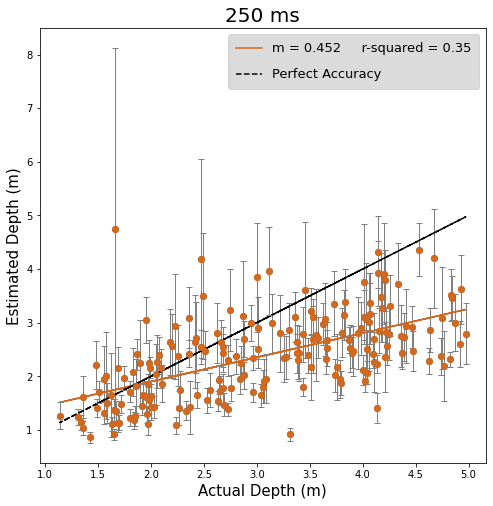

In [35]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X_250 = np.array(stim_250).reshape(-1,1)
y_250 = final_y_250
reg_250 = LinearRegression().fit(X_250, y_250)

#Generated Predictions
y_predicted_250 = reg_250.predict(X_250)
#Plot Our Actual and Predicted Values
plt.plot(X_250, y_250, 'o', color='black', alpha = 0.5);
plt.plot(X_250,y_predicted_250,color='chocolate', label = 'm = ' + str(round(reg_250.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_250.score(X_250, y_250)), 3)))
plt.title("250 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth (m)", fontsize = 15)
plt.plot(X_250, X_250, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X_250, y_250, yerr=ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg_250.coef_))
print("b: {0}".format(reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_250.score(X_250, y_250))

round(float(reg_250.score(X_250, y_250)), 3)

m: [0.58167206]
b: 0.6572790509109907
R-squared:  0.48709161158382686


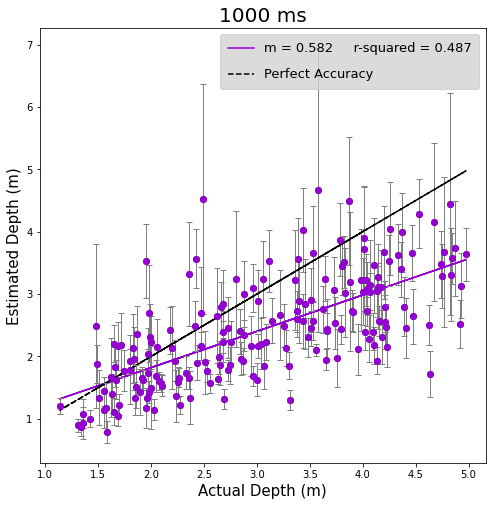

In [36]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X_1000 = np.array(stim_1000).reshape(-1,1)
y_1000 = final_y_1000
reg_1000 = LinearRegression().fit(X_1000, y_1000)

#Generated Predictions
y_predicted_1000 = reg_1000.predict(X_1000)
#Plot Our Actual and Predicted Values
plt.plot(X_1000, y_1000, 'o', color='black', alpha = 0.7);
plt.plot(X_1000,y_predicted_1000,color='darkviolet', label = 'm = ' + str(round(reg_1000.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_1000.score(X_1000, y_1000)), 3)))

plt.title("1000 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth (m)", fontsize = 15)
plt.plot(X_1000, X_1000, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X_1000, y_1000, yerr=ste_1000, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkviolet", mec = "darkviolet", capsize = 3)


legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')



#get coefficients and y intercept
print("m: {0}".format(reg_1000.coef_))
print("b: {0}".format(reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_1000.score(X_1000, y_1000))

In [37]:
def discrim_PC(subjects_dict, VE_df, discrim_data, key):
    '''
    subjects = dictionary of VE subjects for each discrimination trial
    VE_df = df of VE data for a specific duration 
    * these lists correspond in index 
    key = discrim stimulus 
    '''
    subjects = subjects_dict[key]

    
    if len(subjects) > 0:
        df_list = []
        VE_subj_differences = []
        for subj in subjects:
            subj_df = subj_df = VE_df.loc[VE_df['subjID'] == subj]
            _subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
            df_list.append(_subj_df)
            
        df = pd.concat(df_list)       
        df_pivot = trial_pivotTable([df])
        final = trial_getxy(df_pivot)

        final_stim = final[0][0] # stimuli list
        final_y = final[1][0] # avg verbal estimates 
        ste = final[2][0]
        actual_depths = final[3][0] 
        std = final[4][0]

        targetimg0 = key.split('/')[-1]
        folder0 = targetimg0[:-11]
        depth_dur_path0 = 'depth_duration_stimuli/' + folder0 + '/' + targetimg0
        idx0 = np.where(np.array(final_stim) == depth_dur_path0)[0][0]
        avg_estim_stim0 = final_y[idx0]
        std0 = std[idx0]
        ste0 = ste[idx0]

        targetimg1 = discrim_data['depth_discrimination_stimuli/' + key]['stimulus_1'].split('/')[-1]
        folder1 = targetimg1[:-11]
        depth_dur_path1 = 'depth_duration_stimuli/' + folder1 + '/' + targetimg1
        idx1= np.where(np.array(final_stim) == depth_dur_path1)[0][0]
        avg_estim_stim1 = final_y[idx1]
        std1 = std[idx1]
        ste1 = ste[idx1]

        if avg_estim_stim0 < avg_estim_stim1:
            # Which target is CLOSER to you?
            answer = targetimg0
        if avg_estim_stim0 == avg_estim_stim1:
            print(targetimg0, targetimg1)
        if avg_estim_stim0 > avg_estim_stim1:
            answer = targetimg1

        result = {'stimulus_1': targetimg1,
                                 'stimulus_0_avg_estim': avg_estim_stim0,
                                 'stimulus_1_avg_estim': avg_estim_stim1,
                                 'answer': answer,
                                 'std0': std0,
                                 'std1': std1}
        return result

    else:
#         print('No subjects: ', key)
        return None
    


In [38]:
within_VE_answerkey_250 = {} # corresponding answer key for discrimination trials  
n_within_VE_answerkey_250 = {}

for key in discrim_trial_subjects_250:
    within_VE_answerkey_250['depth_discrimination_stimuli/' + key] = discrim_PC(discrim_trial_subjects_250, raw_TAC_250, all_discrim_performance, key)
    n_within_VE_answerkey_250['depth_discrimination_stimuli/' + key] = discrim_PC(discrim_trial_subjects_250, n_TAC_250, all_discrim_performance, key)

within_VE_answerkey_1000 = {} # corresponding answer key for discrimination trials  
n_within_VE_answerkey_1000 = {}
for key in discrim_trial_subjects_1000:
    within_VE_answerkey_1000['depth_discrimination_stimuli/' + key] = discrim_PC(discrim_trial_subjects_1000, raw_TAC_1000, all_discrim_performance, key)
    n_within_VE_answerkey_1000['depth_discrimination_stimuli/' + key] = discrim_PC(discrim_trial_subjects_1000, n_TAC_1000, all_discrim_performance, key)


In [39]:
def subj_discrim_PC(subjects_dict, VE_df, discrim_data, key):
    '''
    For each participant, calculate the difference between two scenes for each discrimination 
    Calculate the mean and standard error for each discrimination difference in the VE data
    '''
    subjects = subjects_dict[key]

    if len(subjects) > 0:
        VE_subj_differences = []
        estims_stim0 = []
        estims_stim1 = []
        df_list = []
        for subj in subjects:
            subj_df = subj_df = VE_df.loc[VE_df['subjID'] == subj]
            _subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
            df_list.append(_subj_df)
                
            targetimg0 = key.split('/')[-1]
            img0_path = 'depth_duration_stimuli/' + key
            dimg0_row = subj_df.loc[subj_df['stimulus'] == img0_path]
            dimg0_estim = dimg0_row['depth_estimate'].unique()[0]
            estims_stim0.append(dimg0_estim)

            targetimg1 = discrim_data['depth_discrimination_stimuli/' + key]['stimulus_1'].split('/')[-1]
            folder1 = targetimg1[:-11]

            img1_path = 'depth_duration_stimuli/' + folder1 + '/' + targetimg1
            dimg1_row = subj_df.loc[subj_df['stimulus'] == img1_path] 
            dimg1_estim = dimg1_row['depth_estimate'].unique()[0]
            estims_stim1.append(dimg1_estim)

            subj_estim_diff = dimg0_estim - dimg1_estim
            VE_subj_differences.append(subj_estim_diff)
                
        
        if np.mean(np.array(estims_stim0)) < np.mean(np.array(estims_stim1)):
            # Which target is CLOSER to you?
            answer = targetimg0
        if np.mean(np.array(estims_stim0)) == np.mean(np.array(estims_stim1)):
            print(targetimg0, targetimg1)
        if np.mean(np.array(estims_stim0)) > np.mean(np.array(estims_stim1)):
            answer = targetimg1

        result = {'stimulus_1': targetimg1,
                      'stimulus_0_avg_estim': np.mean(np.array(estims_stim0)),
                      'stimulus_1_avg_estim': np.mean(np.array(estims_stim1)),
                      'answer': answer,
                      'std0': np.std(np.array(estims_stim0)),
                      'std1': np.std(np.array(estims_stim1)),
                      'ste_diff': stats.sem(np.array(VE_subj_differences))}
        
        return VE_subj_differences, np.mean(np.array(VE_subj_differences)), stats.sem(np.array(VE_subj_differences))
    else:
        return None

        
def subj_discrim_answerkey(subjects_dict, VE_df, discrim_data, key):
    '''
    For each participant, calculate the difference between two scenes for each discrimination 
    Calculate the mean and standard error for each discrimination difference in the VE data
    '''
    subjects = subjects_dict[key]

    if len(subjects) > 0:
        VE_subj_differences = []
        estims_stim0 = []
        estims_stim1 = []
        df_list = []
        for subj in subjects:
            subj_df = subj_df = VE_df.loc[VE_df['subjID'] == subj]
            _subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
            df_list.append(_subj_df)
                
            targetimg0 = key.split('/')[-1]
            img0_path = 'depth_duration_stimuli/' + key
            dimg0_row = subj_df.loc[subj_df['stimulus'] == img0_path]
            dimg0_estim = dimg0_row['depth_estimate'].unique()[0]
            estims_stim0.append(dimg0_estim)

            targetimg1 = discrim_data['depth_discrimination_stimuli/' + key]['stimulus_1'].split('/')[-1]
            folder1 = targetimg1[:-11]

            img1_path = 'depth_duration_stimuli/' + folder1 + '/' + targetimg1
            dimg1_row = subj_df.loc[subj_df['stimulus'] == img1_path] 
            dimg1_estim = dimg1_row['depth_estimate'].unique()[0]
            estims_stim1.append(dimg1_estim)

            subj_estim_diff = dimg0_estim - dimg1_estim
            VE_subj_differences.append(subj_estim_diff)
                
        
        if np.mean(np.array(estims_stim0)) < np.mean(np.array(estims_stim1)):
            # Which target is CLOSER to you?
            answer = targetimg0
        if np.mean(np.array(estims_stim0)) == np.mean(np.array(estims_stim1)):
            print(targetimg0, targetimg1)
        if np.mean(np.array(estims_stim0)) > np.mean(np.array(estims_stim1)):
            answer = targetimg1

        result = {'stimulus_1': targetimg1,
                      'stimulus_0_avg_estim': np.mean(np.array(estims_stim0)),
                      'stimulus_1_avg_estim': np.mean(np.array(estims_stim1)),
                      'answer': answer,
                      'std0': np.std(np.array(estims_stim0)),
                      'std1': np.std(np.array(estims_stim1)),
                      'ste_diff': stats.sem(np.array(VE_subj_differences))}
        
        return result
    else:
        return None    

In [45]:
# raw VE data 
p_VE_answerkey_250 = {}
p_VE_answerkey_1000 = {}

# normalized VE data 
np_VE_answerkey_250 = {}
np_VE_answerkey_1000 = {}

for key in discrim_trial_subjects_250:
    p_VE_answerkey_250['depth_discrimination_stimuli/' + key] = subj_discrim_PC(discrim_trial_subjects_250, raw_TAC_250, all_discrim_performance, key)
    np_VE_answerkey_250['depth_discrimination_stimuli/' + key] = subj_discrim_PC(discrim_trial_subjects_250, n_TAC_250, all_discrim_performance, key)
    
    

for key in discrim_trial_subjects_1000:
    p_VE_answerkey_1000['depth_discrimination_stimuli/' + key] = subj_discrim_PC(discrim_trial_subjects_1000, raw_TAC_1000, all_discrim_performance, key)
    np_VE_answerkey_1000['depth_discrimination_stimuli/' + key] = subj_discrim_PC(discrim_trial_subjects_1000, n_TAC_1000, all_discrim_performance, key)
    

In [46]:
mean_diffs_250 = [p_VE_answerkey_250[key][1] for key in p_VE_answerkey_250 if p_VE_answerkey_250[key] != None]
mean_diffs_1000 = [p_VE_answerkey_1000[key][1] for key in p_VE_answerkey_1000 if p_VE_answerkey_1000[key] != None]

ste_diffs_250 = [p_VE_answerkey_250[key][2] for key in p_VE_answerkey_250 if p_VE_answerkey_250[key] != None]
ste_diffs_1000 = [p_VE_answerkey_1000[key][2] for key in p_VE_answerkey_1000 if p_VE_answerkey_1000[key] != None]

In [49]:
# raw VE data 
final_VE_answerkey_250 = {}
final_VE_answerkey_1000 = {}

# normalized VE data 
n_final_VE_answerkey_250 = {}
n_final_VE_answerkey_1000 = {}

for key in discrim_trial_subjects_250:
    final_VE_answerkey_250['depth_discrimination_stimuli/' + key] = subj_discrim_answerkey(discrim_trial_subjects_250, raw_TAC_250, all_discrim_performance, key)
    n_final_VE_answerkey_250['depth_discrimination_stimuli/' + key] = subj_discrim_answerkey(discrim_trial_subjects_250, n_TAC_250, all_discrim_performance, key)
    
    

for key in discrim_trial_subjects_1000:
    final_VE_answerkey_1000['depth_discrimination_stimuli/' + key] = subj_discrim_answerkey(discrim_trial_subjects_1000, raw_TAC_1000, all_discrim_performance, key)
    n_final_VE_answerkey_1000['depth_discrimination_stimuli/' + key] = subj_discrim_answerkey(discrim_trial_subjects_1000, n_TAC_1000, all_discrim_performance, key)

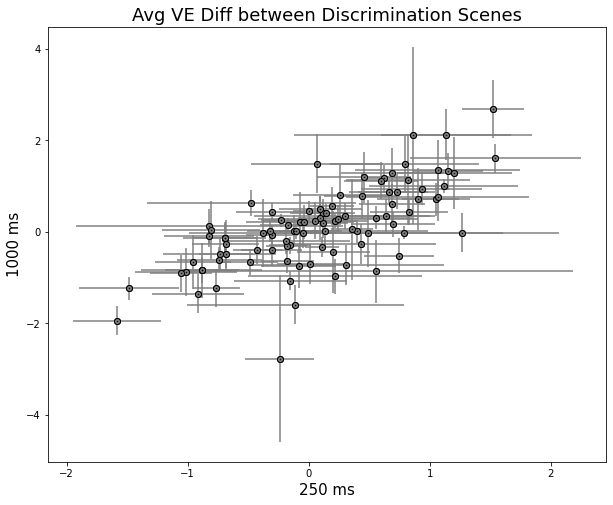

(0.7038661897713235, 2.519236264978356e-15)


In [50]:
plt.figure(figsize=[10,8])
plt.xlabel('250 ms', fontsize=15)
plt.ylabel('1000 ms', fontsize=15)
plt.title('Avg VE Diff between Discrimination Scenes', fontsize=18)
plt.plot(mean_diffs_250, mean_diffs_1000, 'o', color='black')
plt.errorbar(mean_diffs_250, mean_diffs_1000, xerr=ste_diffs_250, fmt="o", mec='black', color='gray')
plt.errorbar(mean_diffs_250, mean_diffs_1000, yerr=ste_diffs_1000, fmt="o", mec='black', ms = 0.5, color='gray')

plt.show();
print(scipy.stats.pearsonr(mean_diffs_250, mean_diffs_1000))

In [51]:
final_discrim

subjID experimentName                 versionName  \
100  119760    DepthScenes  v2_duration_discrimination   
101  119760    DepthScenes  v2_duration_discrimination   
102  119760    DepthScenes  v2_duration_discrimination   
103  119760    DepthScenes  v2_duration_discrimination   
104  119760    DepthScenes  v2_duration_discrimination   
..      ...            ...                         ...   
895  524202    DepthScenes  v2_duration_discrimination   
896  524202    DepthScenes  v2_duration_discrimination   
897  524202    DepthScenes  v2_duration_discrimination   
898  524202    DepthScenes  v2_duration_discrimination   
899  524202    DepthScenes  v2_duration_discrimination   

                  sequenceName  \
100  discrim_jsons/j13_dr.json   
101  discrim_jsons/j13_dr.json   
102  discrim_jsons/j13_dr.json   
103  discrim_jsons/j13_dr.json   
104  discrim_jsons/j13_dr.json   
..                         ...   
895  discrim_jsons/j13_dr.json   
896  discrim_jsons/j13_dr.json   
897  discrim_jsons/j13_dr.json   
898  discrim_jsons/j13_dr.json   
899  discrim_jsons/j13_dr.json   

                                                   url  selected_row  \
100  http://54.235.3.71/FacialAge/BNav_EC2/DepthDur...             1   
101  http://54.235.3.71/FacialAge/BNav_EC2/DepthDur...             1   
102  http://54.235.3.71/FacialAge/BNav_EC2/DepthDur...             1   
103  http://54.235.3.71/FacialAge/BNav_EC2/DepthDur...             1   
104  http://54.235.3.71/FacialAge/BNav_EC2/DepthDur...             1   
..                                                 ...           ...   
895  http://54.235.3.71/FacialAge/BNav_EC2/DepthDur...             1   
896  http://54.235.3.71/FacialAge/BNav_EC2/DepthDur...             1   
897  http://54.235.3.71/FacialAge/BNav_EC2/DepthDur...             1   
898  http://54.235.3.71/FacialAge/BNav_EC2/DepthDur...             1   
899  http://54.235.3.71/FacialAge/BNav_EC2/DepthDur...             1   

     windowWidth  windowHeight  screenWidth  screenHeight  ... trial_RT  \
100         1707           793         1536           864  ...     1566   
101         1707           793         1536           864  ...     2087   
102         1707           793         1536           864  ...     1634   
103         1707           793         1536           864  ...     2059   
104         1707           793         1536           864  ...     1655   
..           ...           ...          ...           ...  ...      ...   
895         1280           698         1280           800  ...     1127   
896         1280           698         1280           800  ...     1090   
897         1280           698         1280           800  ...     1365   
898         1280           698         1280           800  ...     1078   
899         1280           698         1280           800  ...     1858   

    log_fixation  log_sceneDuration1 log_mask1 log_sceneDuration2  log_mask2  \
100         1012                 254       988                250        506   
101         1015                 998      1002                997        506   
102         1013                 250       992                255        500   
103         1009                1000      1004               1000        498   
104         1016                1000       994               1000        492   
..           ...                 ...       ...                ...        ...   
895         1004                 251       995                254        500   
896         1006                 249       997                249        500   
897         1006                 249       996                251        502   
898         1007                 244      1003                251        495   
899         1005                1000       999               1000        496   

     experimentTime  totalTime  age  gender  
100             NaN     756611   58   Woman  
101             NaN     756611   58   Woman  
102             NaN     756611   5

In [52]:
def VE_accuracy(stim0, df, answerkey):
    '''
    Accuracy based on the verbal judgement data 
    '''
    
    """
    args:
        df  
    returns:
        proportion of correct responses, count of correct responses, count of total trials  
    """
    count_correct = 0
    count_incorrect = 0
    count_total = 0
    count_missed = 0
    try:
        VE_correct_answer = answerkey[stim0]['answer']
        for idx, row in df.iterrows(): 
            choice = row["discrim_choice"]
            count_total += 1
            if choice == 0.0:
                image_choice = row["stimulus_0"]

            if choice == 1.0:
                image_choice = row["stimulus_1"]

            if choice == 2.0:
                count_missed += 1

            if choice == 3.0:
                count_missed += 1

            try:
                if image_choice.split('/')[-1] == VE_correct_answer:
                    count_correct += 1
            except:
                pass
            
        p = count_correct/count_total
        n = count_total
        stderr = np.sqrt(p*(1-p)/n)
        return count_correct/count_total, count_correct, count_total, count_missed, stderr
    except:
        return None

    
def main_VE_accuracy(df, answerkey_250, answerkey_1000):
    all_stim0 = df.stimulus_0.unique()
    stimuli_stats = {}
    for stim0 in all_stim0:
        
        # dataframe for stimulus 0
        stim0_df = df.loc[df['stimulus_0'] == stim0]
        # name of stimulus 1
        other_stim = stim0_df.stimulus_1.unique()[0]
        # dataframe where stimulus 0 is presented SECOND (same trial)
        stim1_df = df.loc[df['stimulus_1'] == stim0]
        
        # df for a specific discrimination trial (collapsed on stim presentation order)
        stim_df = pd.concat([stim0_df, stim1_df], ignore_index=True)
        stim_250_df = stim_df[stim_df['duration'] == 250.0]
        stim_1000_df = stim_df[stim_df['duration'] == 1000.0] 
        
#         stim_depthdiff = stim_df['depth_difference'][0]
        
        stim0_depth = stim_df['actual_depth_0'][0]
        stim1_depth = stim_df['actual_depth_1'][0]
        stim_depthbin = np.mean(np.array([stim0_depth,stim1_depth]))
        
        stim_acc_250 = VE_accuracy(stim0, stim_250_df, answerkey_250)
        stim_acc_1000 = VE_accuracy(stim0, stim_1000_df, answerkey_1000)
        
        stim_RT_250 = get_RT(stim_250_df)
        stim_RT_1000 = get_RT(stim_1000_df)
        
        # difference between verbal judgements divided by joint variance 
        # abs(VE1-VE2)/sqrt(stda^2 + std2^2)
        std0_250 = answerkey_250[stim0]['std0']
        std1_250 = answerkey_250[stim0]['std1']
        joint_variance_250 = np.sqrt(std0_250**2 + std1_250**2)
        JV_regressor_250 = abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim'])/joint_variance_250

        std0_1000 = answerkey_1000[stim0]['std0']
        std1_1000 = answerkey_1000[stim0]['std1']
        joint_variance_1000 = np.sqrt(std0_1000**2 + std1_1000**2)
        JV_regressor_1000 = abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim'])/joint_variance_1000
            
        stimuli_stats[stim0] = {'stimulus_1': other_stim,
                                'accuracy_250': stim_acc_250,
                                'accuracy_1000': stim_acc_1000,
                                'avg_depth': stim_depthbin,
                                'VE_depthdifference_250': abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim']), 
                                'VE_depthdifference_1000': abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim']),
                                'RT_250': stim_RT_250,
                                'RT_1000': stim_RT_1000,
                                'JV_regressor_250': JV_regressor_250,
                                'JV_regressor_1000': JV_regressor_1000}
            

        
    
    return stimuli_stats
    
    

def V2_main_VE_accuracy(df, answerkey_250, subjects_dict_250, answerkey_1000, subjects_dict_1000):
    all_stim0 = df.stimulus_0.unique()
    stimuli_stats = {}
    for stim0 in all_stim0:
        
        # dataframe for stimulus 0
        stim0_df = df.loc[df['stimulus_0'] == stim0]
        # name of stimulus 1
        other_stim = stim0_df.stimulus_1.unique()[0]
        # dataframe where stimulus 0 is presented SECOND (same trial)
        stim1_df = df.loc[df['stimulus_1'] == stim0]
        
        # df for a specific discrimination trial (collapsed on stim presentation order)
        stim_df = pd.concat([stim0_df, stim1_df], ignore_index=True)
        stim_250_df = stim_df[stim_df['duration'] == 250.0]
        stim_1000_df = stim_df[stim_df['duration'] == 1000.0]
                
        stim0_depth = stim_df['actual_depth_0'][0]
        stim1_depth = stim_df['actual_depth_1'][0]
        stim_depthbin = np.mean(np.array([stim0_depth,stim1_depth]))
        
        stim_acc_250 = VE_accuracy(stim0, stim_250_df, answerkey_250)
        stim_acc_1000 = VE_accuracy(stim0, stim_1000_df, answerkey_1000)
        
        stim_RT_250 = get_RT(stim_250_df)
        stim_RT_1000 = get_RT(stim_1000_df)
        
        # difference between verbal judgements divided by joint variance 
        # abs(VE1-VE2)/sqrt(stda^2 + std2^2)
        try:
            std0_250 = answerkey_250[stim0]['std0']
            std1_250 = answerkey_250[stim0]['std1']
            joint_variance_250 = np.sqrt(std0_250**2 + std1_250**2)
            JV_regressor_250 = abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim'])/joint_variance_250
            
            std0_1000 = answerkey_1000[stim0]['std0']
            std1_1000 = answerkey_1000[stim0]['std1']
            joint_variance_1000 = np.sqrt(std0_1000**2 + std1_1000**2)
            JV_regressor_1000 = abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim'])/joint_variance_1000
            
            if stim_acc_250 and stim_acc_1000 != None:
                stimuli_stats[stim0] = {'stimulus_1': other_stim,
                                    'accuracy_250': stim_acc_250,
                                    'accuracy_1000': stim_acc_1000,
                                    'avg_depth': stim_depthbin,
                                    'VE_depthdifference_250': abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim']), 
                                    'VE_depthdifference_1000': abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim']),
                                    'RT_250': stim_RT_250,
                                    'RT_1000': stim_RT_1000,
                                    'JV_regressor_250': JV_regressor_250,
                                    'JV_regressor_1000': JV_regressor_1000,
                                    'ste_diff_250': answerkey_250[stim0]['ste_diff'],
                                    'ste_diff_1000': answerkey_1000[stim0]['ste_diff'],
                                    'discrim_ste_250': stim_acc_250[-1],
                                    'discrim_ste_1000': stim_acc_1000[-1]}        
            
        except: 
            std0_250 = answerkey_250[other_stim]['std0']
            std1_250 = answerkey_250[other_stim]['std1']
            joint_variance_250 = np.sqrt(std0_250**2 + std1_250**2)
            JV_regressor_250 = abs(answerkey_250[other_stim]['stimulus_0_avg_estim'] - answerkey_250[other_stim]['stimulus_1_avg_estim'])/joint_variance_250
            
            std0_1000 = answerkey_1000[other_stim]['std0']
            std1_1000 = answerkey_1000[other_stim]['std1']
            joint_variance_1000 = np.sqrt(std0_1000**2 + std1_1000**2)
            JV_regressor_1000 = abs(answerkey_1000[other_stim]['stimulus_0_avg_estim'] - answerkey_1000[other_stim]['stimulus_1_avg_estim'])/joint_variance_1000
            if stim_acc_250 and stim_acc_1000 != None:
                stimuli_stats[stim0] = {'stimulus_1': stim0,
                                'accuracy_250': stim_acc_250,
                                'accuracy_1000': stim_acc_1000,
                                'avg_depth': stim_depthbin,
                                'VE_depthdifference_250': abs(answerkey_250[other_stim]['stimulus_0_avg_estim'] - answerkey_250[other_stim]['stimulus_1_avg_estim']), 
                                'VE_depthdifference_1000': abs(answerkey_1000[other_stim]['stimulus_0_avg_estim'] - answerkey_1000[other_stim]['stimulus_1_avg_estim']),
                                'RT_250': stim_RT_250,
                                'RT_1000': stim_RT_1000,
                                'JV_regressor_250': JV_regressor_250,
                                'JV_regressor_1000': JV_regressor_1000,
                                'ste_diff_250': answerkey_250[other_stim]['ste_diff'],
                                'ste_diff_1000': answerkey_1000[other_stim]['ste_diff'],
                                'discrim_ste_250': stim_acc_250[-1],
                                'discrim_ste_1000': stim_acc_1000[-1]}
        
    return stimuli_stats
            
        
    


In [53]:
w_all_VE_discrim_performance = V2_main_VE_accuracy(final_discrim, final_VE_answerkey_250, discrim_trial_subjects_250, final_VE_answerkey_1000, discrim_trial_subjects_1000) 

In [54]:
# within_VE_answerkey_1000['depth_discrimination_stimuli/001618_2014-06-20_11-37-31_260595134347_rgbf000027-resize_3/001618_2014-06-20_11-37-31_260595134347_rgbf000027-resize_3-target.png']

In [56]:
w_VE_estim_diff_250 = [w_all_VE_discrim_performance[elem]['VE_depthdifference_250'] for elem in w_all_VE_discrim_performance]
w_VE_estim_diff_1000 = [w_all_VE_discrim_performance[elem]['VE_depthdifference_1000'] for elem in w_all_VE_discrim_performance]

w_VE_accuracy_250 = [w_all_VE_discrim_performance[elem]['accuracy_250'][0] for elem in w_all_VE_discrim_performance]
w_VE_accuracy_1000 = [w_all_VE_discrim_performance[elem]['accuracy_1000'][0] for elem in w_all_VE_discrim_performance]

w_avg_RT_250 = [w_all_VE_discrim_performance[elem]['RT_250'][1] for elem in w_all_VE_discrim_performance]
w_avg_RT_1000 = [w_all_VE_discrim_performance[elem]['RT_1000'][1] for elem in w_all_VE_discrim_performance]

w_JV_250 = [w_all_VE_discrim_performance[elem]['JV_regressor_250'] for elem in w_all_VE_discrim_performance]
w_JV_1000 = [w_all_VE_discrim_performance[elem]['JV_regressor_1000'] for elem in w_all_VE_discrim_performance]

w_stediff_250 = [w_all_VE_discrim_performance[elem]['ste_diff_250'] for elem in w_all_VE_discrim_performance]
w_stediff_1000 = [w_all_VE_discrim_performance[elem]['ste_diff_1000'] for elem in w_all_VE_discrim_performance]

w_discrim_ste_250 = [w_all_VE_discrim_performance[elem]['discrim_ste_250'] for elem in w_all_VE_discrim_performance]
w_discrim_ste_1000 = [w_all_VE_discrim_performance[elem]['discrim_ste_1000'] for elem in w_all_VE_discrim_performance]

In [57]:
len(w_discrim_ste_1000)


94

In [59]:
normVE_w_all_VE_discrim_performance = V2_main_VE_accuracy(final_discrim, n_final_VE_answerkey_250, discrim_trial_subjects_250, n_final_VE_answerkey_1000, discrim_trial_subjects_1000) 

In [60]:
normVE_w_VE_estim_diff_250 = [normVE_w_all_VE_discrim_performance[elem]['VE_depthdifference_250'] for elem in normVE_w_all_VE_discrim_performance]
normVE_w_VE_estim_diff_1000 = [normVE_w_all_VE_discrim_performance[elem]['VE_depthdifference_1000'] for elem in normVE_w_all_VE_discrim_performance]

normVE_w_VE_accuracy_250 = [normVE_w_all_VE_discrim_performance[elem]['accuracy_250'][0] for elem in normVE_w_all_VE_discrim_performance]
normVE_w_VE_accuracy_1000 = [normVE_w_all_VE_discrim_performance[elem]['accuracy_1000'][0] for elem in normVE_w_all_VE_discrim_performance]

normVE_w_avg_RT_250 = [normVE_w_all_VE_discrim_performance[elem]['RT_250'][1] for elem in normVE_w_all_VE_discrim_performance]
normVE_w_all_VE_discrim_performancew_avg_RT_1000 = [normVE_w_all_VE_discrim_performance[elem]['RT_1000'][1] for elem in normVE_w_all_VE_discrim_performance]

normVE_w_JV_250 = [normVE_w_all_VE_discrim_performance[elem]['JV_regressor_250'] for elem in normVE_w_all_VE_discrim_performance]
normVE_w_JV_1000 = [normVE_w_all_VE_discrim_performance[elem]['JV_regressor_1000'] for elem in normVE_w_all_VE_discrim_performance]

normVE_w_stediff_250 = [normVE_w_all_VE_discrim_performance[elem]['ste_diff_250'] for elem in normVE_w_all_VE_discrim_performance]
normVE_w_stediff_1000 = [normVE_w_all_VE_discrim_performance[elem]['ste_diff_1000'] for elem in normVE_w_all_VE_discrim_performance]

normVE_w_discrim_ste_250 = [normVE_w_all_VE_discrim_performance[elem]['discrim_ste_250'] for elem in normVE_w_all_VE_discrim_performance]
normVE_w_discrim_ste_1000 = [normVE_w_all_VE_discrim_performance[elem]['discrim_ste_1000'] for elem in normVE_w_all_VE_discrim_performance]

In [61]:
len(w_VE_accuracy_250)

94

#### Overall Accuracy

In [62]:
np.mean(w_VE_accuracy_250), np.mean(w_VE_accuracy_1000)

(0.7127659574468085, 0.7398936170212768)

In [63]:
np.mean(normVE_w_VE_accuracy_250), np.mean(normVE_w_VE_accuracy_1000)

(0.7078014184397163, 0.7345744680851064)

In [64]:
print('250 ms: Correlation between VE discrimination accuracy and average w/in participant verbal estimate difference')
stats.pearsonr(w_VE_accuracy_250, w_VE_estim_diff_250)

250 ms: Correlation between VE discrimination accuracy and average w/in participant verbal estimate difference


(0.37673018607633213, 0.00018217128380279462)

In [65]:
print('250 ms: Correlation between VE discrimination accuracy and average w/in participant normalized verbal estimate difference')
stats.pearsonr(normVE_w_VE_accuracy_250, normVE_w_VE_estim_diff_250)

250 ms: Correlation between VE discrimination accuracy and average w/in participant normalized verbal estimate difference


(0.39217447441730163, 9.259778766342729e-05)

In [66]:
print('1000 ms: Correlation between VE discrimination accuracy and average w/in participant verbal estimate difference')
stats.pearsonr(w_VE_accuracy_1000, w_VE_estim_diff_1000)

1000 ms: Correlation between VE discrimination accuracy and average w/in participant verbal estimate difference


(0.21804230039579786, 0.03475633258184831)

In [67]:
print('1000 ms: Correlation between VE discrimination accuracy and average w/in participant normalized verbal estimate difference')
stats.pearsonr(normVE_w_VE_accuracy_1000, normVE_w_VE_estim_diff_1000)

1000 ms: Correlation between VE discrimination accuracy and average w/in participant normalized verbal estimate difference


(0.2702507083510041, 0.00843033117111102)

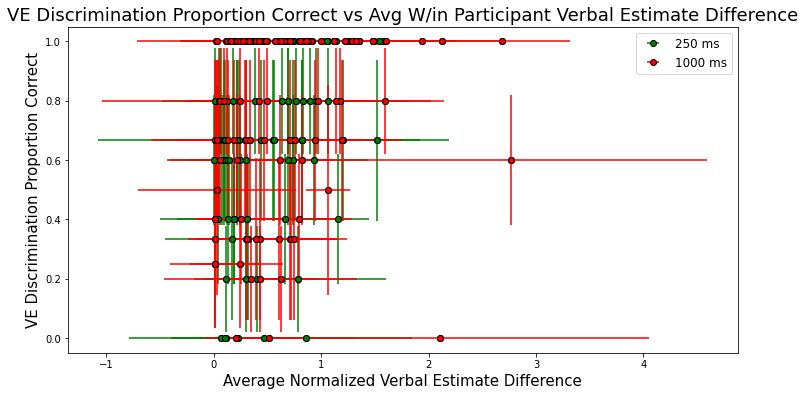

In [68]:
plt.figure(figsize=[12,6])

plt.errorbar(np.array(w_VE_estim_diff_250), np.array(w_VE_accuracy_250), xerr=np.array(w_stediff_250), fmt="o", mec='black', color='green', label='250 ms')
plt.errorbar(np.array(w_VE_estim_diff_250), np.array(w_VE_accuracy_250), yerr=np.array(w_discrim_ste_250), fmt="o", mec='black', color='green')


plt.errorbar(np.array(w_VE_estim_diff_1000), np.array(w_VE_accuracy_1000), xerr=np.array(w_stediff_1000), fmt="o", mec='black', color='red', label='1000 ms')
plt.errorbar(np.array(w_VE_estim_diff_1000), np.array(w_VE_accuracy_1000), yerr=np.array(w_discrim_ste_1000), fmt="o", mec='black', color='red')

# plt.plot(np.array(w_VE_estim_diff_1000), np.array(w_VE_accuracy_1000), 'ro', label='1000 ms')
plt.xlabel('Average Normalized Verbal Estimate Difference', fontsize=15)
plt.ylabel('VE Discrimination Proportion Correct', fontsize = 15)
plt.legend(fontsize = 12)
plt.title('VE Discrimination Proportion Correct vs Avg W/in Participant Verbal Estimate Difference', fontsize = 18)
plt.show();

m: [0.28300967]
b: 0.5564137815004941
R-squared:  0.14192563310110795


Text(0.5, 1.0, '250 ms: Accuracy')

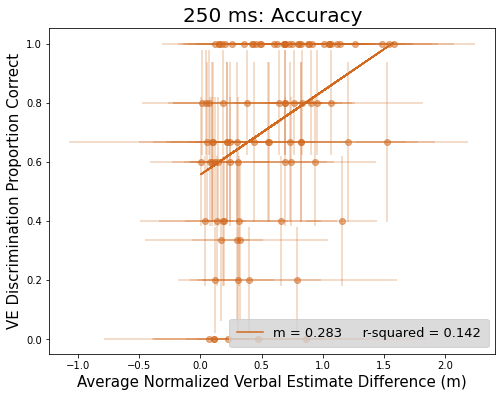

In [69]:
#run regression
plt.figure(figsize=[8,6])
VE_X_250 = np.array(w_VE_estim_diff_250).reshape(-1,1)
VE_PC_250 = w_VE_accuracy_250
VE_PC_reg_250 = LinearRegression().fit(VE_X_250, VE_PC_250)

#Generated Predictions
PC_predicted_250 = VE_PC_reg_250.predict(VE_X_250)
#Plot Our Actual and Predicted Values
plt.errorbar(VE_X_250, VE_PC_250,fmt='o', color='chocolate', alpha = 0.3, xerr = np.array(w_stediff_250));
plt.errorbar(VE_X_250, VE_PC_250,fmt='o', color='chocolate', alpha = 0.3, yerr = np.array(w_discrim_ste_250));
# plt.plot(VE_X_250, VE_PC_250, 'o', color='chocolate', alpha = 0.3);
plt.plot(VE_X_250, PC_predicted_250,color='chocolate', label = 'm = ' + str(round(VE_PC_reg_250.coef_[0], 3))
         + '     r-squared = ' + str(round(float(VE_PC_reg_250.score(VE_X_250, VE_PC_250)), 3)))
plt.xlabel("Average Normalized Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("VE Discrimination Proportion Correct", fontsize = 15)

#get coefficients and y intercept
print("m: {0}".format(VE_PC_reg_250.coef_))
print("b: {0}".format(VE_PC_reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", VE_PC_reg_250.score(VE_X_250, VE_PC_250))


legend = plt.legend(loc = 4, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.title("250 ms: Accuracy", fontsize = 20)


m: [0.10949703]
b: 0.6665291580806867
R-squared:  0.04754244476189129


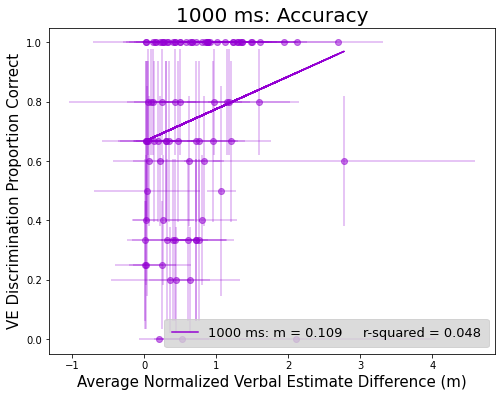

In [70]:
plt.figure(figsize=[8,6])

VE_X_1000 = np.array(w_VE_estim_diff_1000).reshape(-1,1)
VE_PC_1000 = w_VE_accuracy_1000
VE_PC_reg_1000 = LinearRegression().fit(VE_X_1000, VE_PC_1000)

#Generated Predictions
PC_predicted_1000 = VE_PC_reg_1000.predict(VE_X_1000)
#Plot Our Actual and Predicted Values

plt.errorbar(VE_X_1000, VE_PC_1000,fmt='o', color='darkviolet', alpha = 0.3, xerr = np.array(w_stediff_1000));
plt.errorbar(VE_X_1000, VE_PC_1000,fmt='o', color='darkviolet', alpha = 0.3, yerr = np.array(w_discrim_ste_1000));

# plt.plot(VE_X_1000, VE_PC_1000, 'o', color='darkviolet', alpha = 0.3);
plt.plot(VE_X_1000, PC_predicted_1000,color='darkviolet', label = '1000 ms: m = ' + str(round(VE_PC_reg_1000.coef_[0], 3))
         + '     r-squared = ' + str(round(float(VE_PC_reg_1000.score(VE_X_1000, VE_PC_1000)), 3)))

legend = plt.legend(loc = 4, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

#get coefficients and y intercept
print("m: {0}".format(VE_PC_reg_1000.coef_))
print("b: {0}".format(VE_PC_reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", VE_PC_reg_1000.score(VE_X_1000, VE_PC_1000))

plt.xlabel("Average Normalized Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("VE Discrimination Proportion Correct", fontsize = 15)


plt.title("1000 ms: Accuracy", fontsize = 20)

plt.show();

In [71]:
stats.pearsonr(w_VE_accuracy_250, w_VE_accuracy_1000)

(0.29678303484055285, 0.003676475804120126)

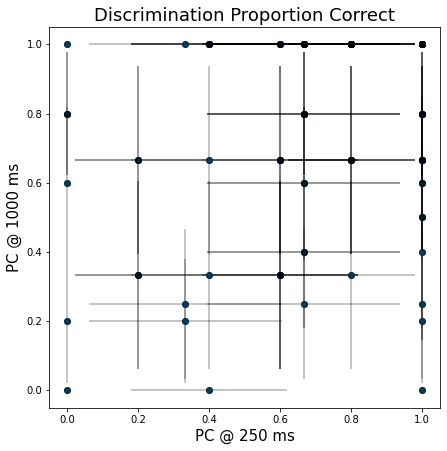

In [72]:
plt.figure(figsize=[7,7])
plt.xlabel('PC @ 250 ms', fontsize=15)
plt.ylabel('PC @ 1000 ms', fontsize=15)

plt.errorbar(w_VE_accuracy_250, w_VE_accuracy_1000, fmt='o', color='black', alpha = 0.3, xerr = np.array(w_discrim_ste_250));
plt.errorbar(w_VE_accuracy_250, w_VE_accuracy_1000, fmt='o', color='black', alpha = 0.3, yerr = np.array(w_discrim_ste_1000));


plt.plot(w_VE_accuracy_250,w_VE_accuracy_1000, 'o' )
plt.title('Discrimination Proportion Correct', fontsize = 18)
plt.show();

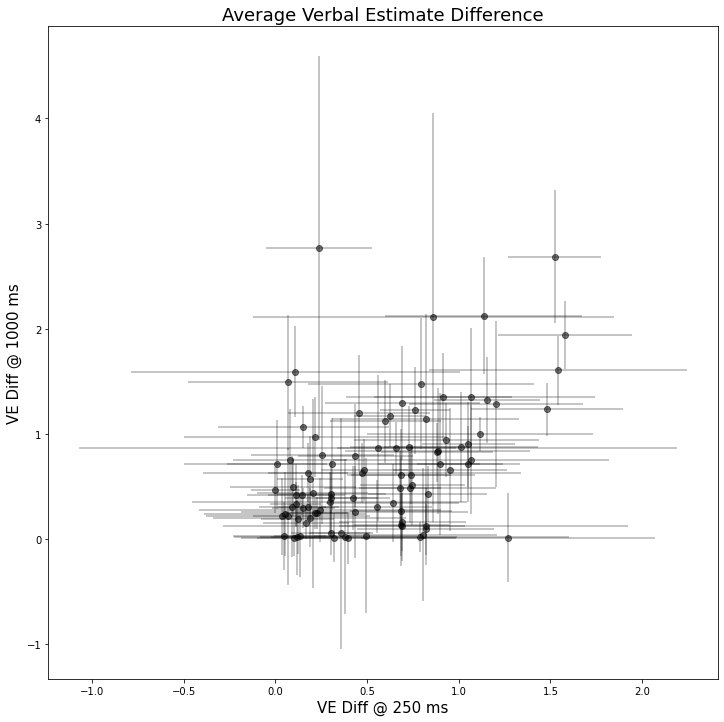

In [73]:
plt.figure(figsize=[12,12])
plt.xlabel('VE Diff @ 250 ms', fontsize=15)
plt.ylabel('VE Diff @ 1000 ms', fontsize=15)

plt.errorbar(w_VE_estim_diff_250, w_VE_estim_diff_1000, fmt='o', color='black', alpha = 0.3, xerr = np.array(w_stediff_250));
plt.errorbar(w_VE_estim_diff_250, w_VE_estim_diff_1000, fmt='o', color='black', alpha = 0.3, yerr = np.array(w_stediff_1000));

plt.title('Average Verbal Estimate Difference', fontsize = 18)
plt.show();

# UPDATED REGRESSOR: Difference between verbal judgements divided by joint variance 

In [74]:
print('250 ms: Correlation between VE discrimination accuracy and difference between w/in participant verbal judgements divided by joint variance ')
stats.pearsonr(w_VE_accuracy_250, w_JV_250)

250 ms: Correlation between VE discrimination accuracy and difference between w/in participant verbal judgements divided by joint variance 


(0.3625913039631241, 0.00032884697514883325)

In [75]:
print('1000 ms: Correlation between VE discrimination accuracy and difference between w/in participant divided by joint variance ')
stats.pearsonr(w_VE_accuracy_1000, w_JV_1000)

1000 ms: Correlation between VE discrimination accuracy and difference between w/in participant divided by joint variance 


(0.37602747890677424, 0.00018771866980466653)

m: [0.376139]
b: 0.5893055579619568
R-squared:  0.13147245370967908


Text(0.5, 1.0, '250 ms')

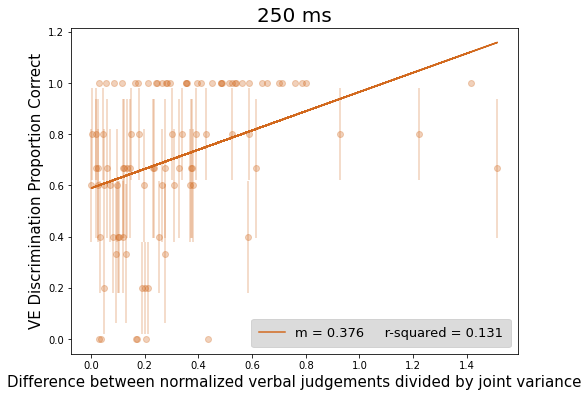

In [91]:
#run regression
plt.figure(figsize=[8,6])
JV_X_250 = np.array(w_JV_250).reshape(-1,1)
VE_PC_250 = w_VE_accuracy_250
JV_PC_reg_250 = LinearRegression().fit(JV_X_250, VE_PC_250)

#Generated Predictions
JV_PC_predicted_250 = JV_PC_reg_250.predict(JV_X_250)
#Plot Our Actual and Predicted Values
plt.errorbar(JV_X_250, VE_PC_250,fmt='o', color='chocolate', alpha = 0.3, yerr = np.array(w_discrim_ste_250));
# plt.plot(JV_X_250, VE_PC_250, 'o', color='chocolate', alpha = 0.3);
plt.plot(JV_X_250, JV_PC_predicted_250,color='chocolate', label = 'm = ' + str(round(JV_PC_reg_250.coef_[0], 3))
         + '     r-squared = ' + str(round(float(JV_PC_reg_250.score(JV_X_250, VE_PC_250)), 3)))
plt.xlabel("Difference between normalized verbal judgements divided by joint variance", fontsize = 15)
plt.ylabel("VE Discrimination Proportion Correct", fontsize = 15)

#get coefficients and y intercept
print("m: {0}".format(JV_PC_reg_250.coef_))
print("b: {0}".format(JV_PC_reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", JV_PC_reg_250.score(JV_X_250, VE_PC_250))


legend = plt.legend(loc = 4, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.title("250 ms", fontsize = 20)


m: [0.38195715]
b: 0.6066641470237613
R-squared:  0.1413966648929844


Text(0.5, 1.0, '1000 ms')

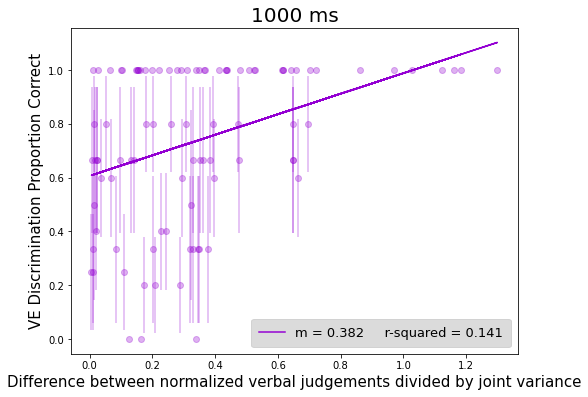

In [77]:
#run regression
plt.figure(figsize=[8,6])
JV_X_1000 = np.array(w_JV_1000).reshape(-1,1)
VE_PC_1000 = w_VE_accuracy_1000
JV_PC_reg_1000 = LinearRegression().fit(JV_X_1000, VE_PC_1000)

#Generated Predictions
JV_PC_predicted_1000 = JV_PC_reg_1000.predict(JV_X_1000)
#Plot Our Actual and Predicted Values
plt.errorbar(JV_X_1000, VE_PC_1000,fmt='o', color='darkviolet', alpha = 0.3, yerr = np.array(w_discrim_ste_1000));
# plt.plot(JV_X_1000, VE_PC_1000, 'o', color='darkviolet', alpha = 0.3);
plt.plot(JV_X_1000, JV_PC_predicted_1000,color='darkviolet', label = 'm = ' + str(round(JV_PC_reg_1000.coef_[0], 3))
         + '     r-squared = ' + str(round(float(JV_PC_reg_1000.score(JV_X_1000, VE_PC_1000)), 3)))
plt.xlabel("Difference between normalized verbal judgements divided by joint variance", fontsize = 15)
plt.ylabel("VE Discrimination Proportion Correct", fontsize = 15)

#get coefficients and y intercept
print("m: {0}".format(JV_PC_reg_1000.coef_))
print("b: {0}".format(JV_PC_reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", JV_PC_reg_1000.score(JV_X_1000, VE_PC_1000))


legend = plt.legend(loc = 4, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.title("1000 ms", fontsize = 20)


(0.5293088079363867, 4.136458499502668e-08)


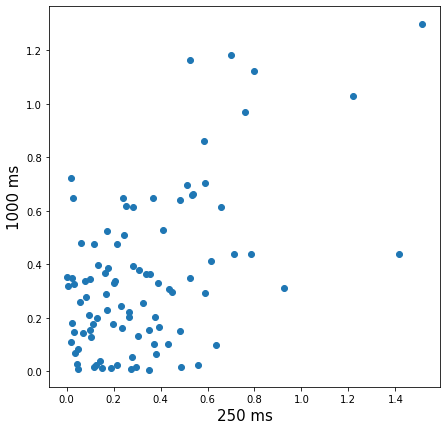

In [78]:
print(stats.pearsonr(w_JV_250, w_JV_1000))
plt.figure(figsize=[7,7])
plt.xlabel('250 ms', fontsize=15)
plt.ylabel('1000 ms', fontsize=15)
plt.plot(w_JV_250,w_JV_1000, 'o' )
plt.show();



In [79]:
print('250 ms: Correlation between average discrimination RT and difference between verbal judgements divided by joint variance ')
stats.pearsonr(w_avg_RT_250, w_JV_250)

250 ms: Correlation between average discrimination RT and difference between verbal judgements divided by joint variance 


(-0.2743628743868176, 0.007450363208669877)

In [80]:
print('1000 ms: Correlation between average discrimination RT and difference between verbal judgements divided by joint variance ')
stats.pearsonr(w_avg_RT_1000, w_JV_1000)

1000 ms: Correlation between average discrimination RT and difference between verbal judgements divided by joint variance 


(-0.12653357994842385, 0.22426477593989874)

m: [-169.17049775]
b: 1098.292035935973
R-squared:  0.07527498684179668


Text(0.5, 1.0, '250 ms: RT')

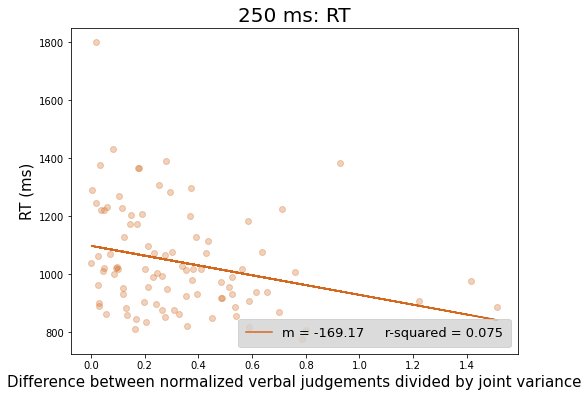

In [81]:
#run regression
plt.figure(figsize=[8,6])
JV_X_250 = np.array(w_JV_250).reshape(-1,1)
VE_PC_250 = w_avg_RT_250
JV_PC_reg_250 = LinearRegression().fit(JV_X_250, VE_PC_250)

#Generated Predictions
JV_PC_predicted_250 = JV_PC_reg_250.predict(JV_X_250)
#Plot Our Actual and Predicted Values
plt.plot(JV_X_250, VE_PC_250, 'o', color='chocolate', alpha = 0.3);
plt.plot(JV_X_250, JV_PC_predicted_250,color='chocolate', label = 'm = ' + str(round(JV_PC_reg_250.coef_[0], 3))
         + '     r-squared = ' + str(round(float(JV_PC_reg_250.score(JV_X_250, VE_PC_250)), 3)))
plt.xlabel("Difference between normalized verbal judgements divided by joint variance", fontsize = 15)
plt.ylabel("RT (ms)", fontsize = 15)

#get coefficients and y intercept
print("m: {0}".format(JV_PC_reg_250.coef_))
print("b: {0}".format(JV_PC_reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", JV_PC_reg_250.score(JV_X_250, VE_PC_250))


legend = plt.legend(loc = 4, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.title("250 ms: RT", fontsize = 20)

m: [-67.26832224]
b: 1000.4303536264364
R-squared:  0.016010746854564273


Text(0.5, 1.0, '1000 ms: RT')

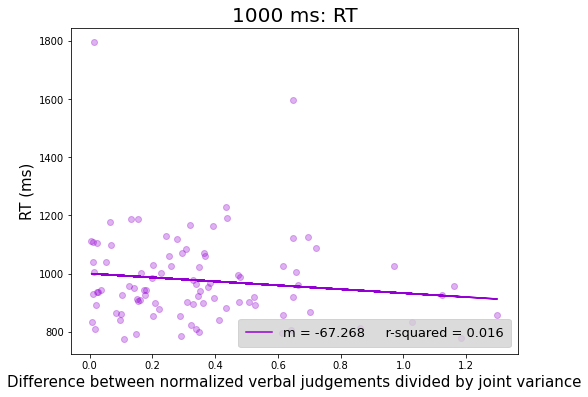

In [82]:
#run regression
plt.figure(figsize=[8,6])
JV_X_1000 = np.array(w_JV_1000).reshape(-1,1)
VE_PC_1000 = w_avg_RT_1000
JV_PC_reg_1000 = LinearRegression().fit(JV_X_1000, VE_PC_1000)

#Generated Predictions
JV_PC_predicted_1000 = JV_PC_reg_1000.predict(JV_X_1000)
#Plot Our Actual and Predicted Values
plt.plot(JV_X_1000, VE_PC_1000, 'o', color='darkviolet', alpha = 0.3);
plt.plot(JV_X_1000, JV_PC_predicted_1000,color='darkviolet', label = 'm = ' + str(round(JV_PC_reg_1000.coef_[0], 3))
         + '     r-squared = ' + str(round(float(JV_PC_reg_1000.score(JV_X_1000, VE_PC_1000)), 3)))
plt.xlabel("Difference between normalized verbal judgements divided by joint variance", fontsize = 15)
plt.ylabel("RT (ms)", fontsize = 15)

#get coefficients and y intercept
print("m: {0}".format(JV_PC_reg_1000.coef_))
print("b: {0}".format(JV_PC_reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", JV_PC_reg_1000.score(JV_X_1000, VE_PC_1000))


legend = plt.legend(loc = 4, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.title("1000 ms: RT", fontsize = 20)

## Inverse Efficiency Score

It is calculated by dividing RT by 1 – the proportion of Errors (PE), or the proportion of correct responses (PC).

https://www.readcube.com/articles/10.5334/pb-51-1-5

In [83]:
def inverse_efficiency_score(PC, RT):
    """
    Input:
        PC - proportion correct
        RT - reaction time 
    Output:
        ies - inverse efficiency score
    """
    
    ies = RT / PC
    
    return ies

In [84]:
w_all_VE_discrim_performance['depth_discrimination_stimuli/001618_2014-06-20_11-37-31_260595134347_rgbf000027-resize_3/001618_2014-06-20_11-37-31_260595134347_rgbf000027-resize_3-target.png']

KeyError: 'depth_discrimination_stimuli/001618_2014-06-20_11-37-31_260595134347_rgbf000027-resize_3/001618_2014-06-20_11-37-31_260595134347_rgbf000027-resize_3-target.png'

In [85]:
ies_250 = [inverse_efficiency_score(w_all_VE_discrim_performance[key]['accuracy_250'][0], w_all_VE_discrim_performance[key]['RT_250'][1]) for key in w_all_VE_discrim_performance]

ies_1000 = [inverse_efficiency_score(w_all_VE_discrim_performance[key]['accuracy_1000'][0], w_all_VE_discrim_performance[key]['RT_1000'][1]) for key in w_all_VE_discrim_performance]


/Users/prachi/Documents/depth_duration/experiment/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [86]:
depthdiff_250 = np.array([w_all_VE_discrim_performance[key]['VE_depthdifference_250'] for key in w_all_VE_discrim_performance])
depthdiff_1000 = np.array([w_all_VE_discrim_performance[key]['VE_depthdifference_1000'] for key in w_all_VE_discrim_performance])


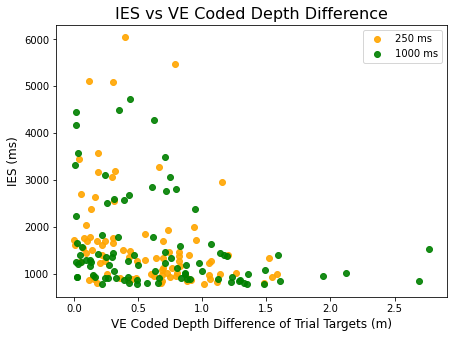

In [87]:
plt.figure(figsize=[7,5])
plt.plot(depthdiff_250, np.array(ies_250), 'o', color='orange', alpha = 0.9, label='250 ms')
plt.plot(depthdiff_1000, np.array(ies_1000), 'o', color='green', alpha = 0.9, label='1000 ms')
plt.xlabel('VE Coded Depth Difference of Trial Targets (m)', fontsize = 12)
plt.ylabel('IES (ms)', fontsize = 12)
plt.legend(loc='upper right')
plt.title('IES vs VE Coded Depth Difference', fontsize=16)
plt.show();



ValueError: supplied range of [777.0, inf] is not finite

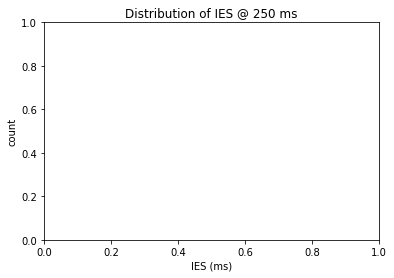

In [88]:
plt.title('Distribution of IES @ 250 ms')
plt.xlabel('IES (ms)')
plt.ylabel('count')
plt.hist(np.array(ies_250), color='orange')
plt.show();


ValueError: supplied range of [779.6, inf] is not finite

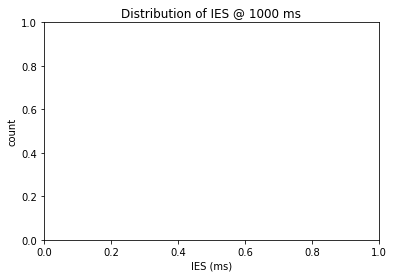

In [89]:
plt.title('Distribution of IES @ 1000 ms')
plt.xlabel('IES (ms)')
plt.ylabel('count')
plt.hist(np.array(ies_1000), color='green')
plt.show();